In [1]:
#import sys, os
#sys.path.append(os.path.expanduser('~/git/botop/build'))
#import libry as ry
from robotic import ry
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
C = ry.Config()
#C.addFile(ry.raiPath('../rai-robotModels/scenarios/pandasTable.g'))
C.addFile(ry.raiPath('../rai-robotModels/scenarios/pandaSingle.g'))

obj = C.addFrame('obj')
obj.setPose('t(0. 0.1 0.8)')
obj.setShape(ry.ST.ssBox, size=[.05,.05,.05,.005])
obj.setColor([1,.0,0])
obj.setMass(.1)
obj.setContact(True)
#cameraFrame = C.addFrame("myCamera")
#cameraFrame.setShape(ry.ST.marker, [0.3])
# cameraFrame.setPosition([0,0,2.0])
#cameraFrame.setPosition([0,1.0,2.0])
#cameraFrame.setQuaternion([1,-0.5,0,1])
C.view()

0

In [3]:
bot = ry.BotOp(C, False)
bot.home(C)

[rai] bot.cpp:getImageAndDepth:294(0) creating camera sensor 'camera'


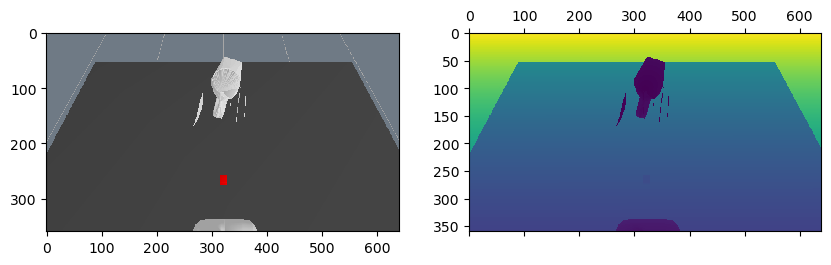

In [4]:
rgb, depth = bot.getImageAndDepth("camera")

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 2)
axs[0].imshow(rgb)
axs[1].matshow(depth)
plt.show()

From the lecture slides, we learned
$$\hat x = f\frac{X}{Z}+p_x,~\hat y = f\frac{Y}{Z}+p_y,$$
where
- $\hat x, \hat y$ are image coordinates ($u$-$v$ or pixel),
- $X, Y, Z$ represent camera coordinates, and
- $p_x, p_y$ are the image offset.

Since we know the $Z$ value of each pixel, we can compute their 3D coordinate (in camera frame):
$$ X = Z\frac{\hat x-p_x}{f},~  Y = Z\frac{\hat y-p_y}{f}.$$

In [5]:
fxypxy = bot.getCameraFxypxy("camera")
print(fxypxy)
depth.shape
cameraFrame = C.getFrame("camera")

[322.19998169 322.19998169 320.         180.        ]


(322, 267)


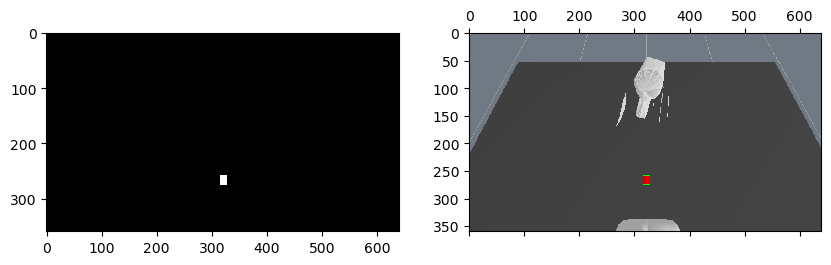

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 2)

color = cv.cvtColor(rgb, cv.COLOR_BGR2RGB)

        #cv.imshow('OPENCV - rgb', color)
        
# find redish pixel
color_HSV = cv.cvtColor(color, cv.COLOR_BGR2HSV)

result = color_HSV.copy()
lower1 = np.array([0,15,10])
upper1 = np.array([30,255,255])
mask1 = cv.inRange(color_HSV, lower1, upper1)

lower2 = np.array([330,15,10])
upper2 = np.array([360,255,255])
mask2 = cv.inRange(color_HSV, lower2, upper2)

# display binary mask
result[np.where(mask1==0) and np.where(mask2==0)] = 0
result[np.where(mask1!=0) or  np.where(mask2!=0)] = 255
#cv.imshow('OPENCV - binary mask', result)
axs[0].imshow(result)
# segementation
imgray = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
contours, _ = cv.findContours(imgray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# display segements
#cv.imshow('OPENCV - rgb contours', cv.drawContours(color, contours, -1, (0,255,0), 1))
axs[1].matshow(cv.drawContours(rgb, contours, -1, (0,255,0), 1))
# print center of segment
x = 0
y = 0
w = 0
h = 0
for c in contours:
    #if cv.contourArea(c) <= 50 :
    #    continue    
    x,y,w,h = cv.boundingRect(c)
    x = int(x+ w/2)
    y = int(y+ h/2)
    center = (x,y)
    print (center)

plt.show()

In [13]:
fx, fy = fxypxy[0], fxypxy[1]
px, py = fxypxy[2], fxypxy[3]
R, t = cameraFrame.getRotationMatrix(), cameraFrame.getPosition()
H, W = depth.shape



print(px)
print(py)

    
Z = depth[x,y]
#temp = x
#y = x # 0.007, -0.32 , -1.157
#x = temp

point = [1, 2, 3]
## depth is sign-fliped, j: right, i: down
point[0] = Z * (x - px) / fx;
point[1] = -Z * (y - py) / fy;
point[2] = -Z

point[2] -= (w/ fx)/2

print(str(point))

## Coordinate transformation (from camera to world) 
#point = R@point 

tmp = C.addFrame( "center of red", 'camera')
tmp.setShape(ry.ST.ssBox, size=[.05,.05,.05,.005])
tmp.setColor([1,0,0,.5])
tmp.setRelativePosition(point)
#tmp.setRelativePose('d(45 0 1 0)')
#tmp.setRelativePosition([1,1,1])

C.view()

320.0
180.0
[0.006576051706886507, -0.286058249249563, -1.0811275072593034]


0

In [8]:
#C2 = ry.Config()
#pclFrame = C2.addFrame('pcl')
#pclFrame.setPosition(cameraFrame.getPosition())
#pclFrame.setQuaternion(cameraFrame.getQuaternion())
#C.delFrame('pcl')
#pclFrame = C.addFrame('pcl', 'camera')
#
#rgb, points = bot.getPointCloud('camera', False)
#pclFrame.setPointCloud(points, rgb)
#pclFrame.setColor([1.,0.,0.]) #only to see it when overlaying with truth
#C.view_recopyMeshes()
#C.view()

In [14]:
# manually define frames as an endeff waypoints, relative to box:
way0 = C.addFrame('way0', 'center of red')
way1 = C.addFrame('way1', 'center of red')

way0.setShape(ry.ST.marker, size=[.1])
way0.setRelativePose('t(0 0 .1) d(90 0 0 1)')

way1.setShape(ry.ST.marker, size=[.1])
way1.setRelativePose('d(90 0 0 1)')

C.view()

komo = ry.KOMO()
komo.setConfig(C, True)
komo.setTiming(2., 1, 5., 0)
komo.addControlObjective([], 0, 1e-0)
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq);
komo.addObjective([], ry.FS.jointLimits, [], ry.OT.ineq);
komo.addObjective([1.], ry.FS.poseDiff, ['l_gripper', 'way0'], ry.OT.eq, [1e1]);
komo.addObjective([2.], ry.FS.poseDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1]);

ret = ry.NLP_Solver() \
    .setProblem(komo.nlp()) \
    .setOptions( stopTolerance=1e-2, verbose=4 ) \
    .solve()
print(ret)

komo.view(False, "waypoints solution")

komo.view_close()
path = komo.getPath()

bot = ry.BotOp(C, False)
bot.home(C)

bot.home(C)

bot.gripperOpen(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C, .1)
    

bot.move(path, [2., 3.])
while bot.getTimeToEnd()>0:
    bot.sync(C, .1)
    
bot.gripperClose(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C, .1)
    
bot.home(C)

bot.gripperOpen(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C, .1)

====nlp==== method:AugmentedLagrangian bounded: yes
==nlp== it:0 evals:0 mu:1 nu:1 muLB:0.1
----newton---- initial point f(x):57.3776 alpha:1 beta:1
--newton-- it:   1  |Delta|:        0.2  alpha:          1  evals:   2  f(y):    45.6959  ACCEPT
--newton-- it:   2  |Delta|:        0.2  alpha:          1  evals:   3  f(y):    34.8687  ACCEPT
--newton-- it:   3  |Delta|:        0.2  alpha:          1  evals:   4  f(y):    25.2614  ACCEPT
--newton-- it:   4  |Delta|:        0.2  alpha:          1  evals:   5  f(y):    17.2556  ACCEPT
--newton-- it:   5  |Delta|:        0.2  alpha:          1  evals:   6  f(y):    11.4421  ACCEPT
--newton-- it:   6  |Delta|:        0.2  alpha:          1  evals:   7  f(y):     11.634  reject (lineSearch:0)
                    (line search)        alpha:        0.5  evals:   8  f(y):    10.4236  ACCEPT
--newton-- it:   7  |Delta|:        0.2  alpha:       0.75  evals:   9  f(y):    9.26754  ACCEPT
--newton-- it:   8  |Delta|:        0.2  alpha:          1  

[rai] simulation.cpp:~BotThreadedSim:60(0) shutting down SimThread
[rai] simulation.cpp:~Simulation:153(0) shutting down Simulation


In [10]:
C.delFrame('pcl')

[rai] kin.cpp:getFrame:379(-1) cannot find frame named 'pcl'


In [11]:
bot.sync(C)

False

In [ ]:
cv.destroyAllWindows()
del bot
del C